In [1]:
import numpy as np
import pandas as pd

import sys, os
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
from scipy.special import digamma
from scipy.stats import wishart
from typing import Union


sys.path.append(os.path.dirname(os.getcwd()))
from pyfrechet.metric_spaces import MetricData, LogCholesky, spd_to_log_chol, log_chol_to_spd, LogEuclidean, CustomAffineInvariant, CustomLogEuclidean, AffineInvariant
from pyfrechet.regression.bagged_regressor import BaggedRegressor

INFO: Using numpy backend


## Functions

In [2]:
def coverage_results(dfs: list, dist: str = 'LC') -> pd.DataFrame:
    """Create a dataframe with the data to be analyzed from the results files."""
    coverage_df=pd.DataFrame(columns=['sample_index', 'train_size', 'df', 'y_train_data', 'train_predictions', 'OOB_errors', 'OOB_quantile', 'forest'])
    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        if file.endswith('.npy') and file.split('_')[0] == dist:
            infile=open(os.path.join(os.getcwd(), 'results/' + file), 'rb')
            result=np.load(infile, allow_pickle=True).item()
            infile.close()
            coverage_df=pd.concat([coverage_df, 
                                    pd.DataFrame({  'distance': dist,
                                                    'sample_index': int(file.split('_')[2][4:]),
                                                    'train_size': int(file.split('_')[3][1:]),
                                                    'df': int(file.split('_')[4][2:]),
                                                    'y_train_data': [result['y_train_data']],
                                                    'train_predictions': [result['train_predictions']],
                                                    'forest': [result['forest']],
                                                }, index=pd.RangeIndex(0,1))],
                                    ignore_index=True)
        
    coverage_df['train_size']=coverage_df['train_size'].astype('category')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('category')
    coverage_df['df'] = coverage_df.df.astype('category')
    return coverage_df


def generate_random_spd_matrix(q_array, limits_unif = 30, seed = 1):
    """Generate a random q x q symmetric positive definite (SPD) matrix."""
    np.random.RandomState(seed)
    
    q_array = np.array(q_array, dtype = int)
    # Ensure the matrices are symmetric positive definite
    mat = [(np.random.rand(q_array[i], q_array[i])-1/2)*limits_unif for i in range(len(q_array))]
    return [np.dot(mat[i], mat[i].T) for i in range(len(q_array))]

# Define the matrices to interpolate
Sigma_1 = np.array([[1, -0.6],
                  [-0.6, 0.5]])
Sigma_2 = np.array([[1, 0],
                  [0, 1]])
Sigma_3 = np.array([[0.5, 0.4],
                  [0.4, 1]])

Sigmas = (Sigma_1, Sigma_2, Sigma_3)

def Sigma_t(t_array, Sigma_array):
    """Provides an array with the matrices given by a regression model that interpolates between four matrices."""  
    """The regression starts with Sigma_1 and then goes to Sigma_2 and Sigma_3 and ends in Sigma_4."""
    
    # Define time intervals for interpolation
    t_array = np.array(t_array)
    t_array = t_array[:, None, None]

    # Return the interpolated matrices
    return np.where(t_array < 0.5, np.cos(np.pi*t_array)**2 * Sigma_array[0] + (1 - np.cos(np.pi*(1-t_array))**2) * Sigma_array[1], 0) + np.where(t_array >= 0.5, (1 - np.cos(np.pi*t_array)**2) * Sigma_array[1] + np.cos(np.pi*(1-t_array))**2 * Sigma_array[2], 0)


def sim_regression_matrices(Sigmas: tuple,
                            t: np.array,
                            df: int=2):
    t = np.array(t)
    
    #Simulate the time for regression (sample_t) and the true time (true_t)
    q = Sigmas[0].shape[0]

    c_dq = 2 * np.exp((1 / q) * sum( digamma((df - np.arange(1, q + 1) + 1 ) / 2) ))
    sigma_t = Sigma_t(t, Sigmas)
    sample_Y = [wishart( df=df, scale = sigma_t[k] / c_dq ).rvs( size=1 ) for k in range(t.shape[0])]
    return {'t': t, 'y': sample_Y}


def plot_ellipse(mat: np.ndarray, ax, 
                 xy: tuple=(0,0),
                 scale_factor=1,
                 edgecolor='red',
                 facecolor='None',
                 linewidth=2,
                 alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(mat)
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=xy,
                  width=scale_factor*np.sqrt(eigenvalues[0]),
                  height=scale_factor*np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor=facecolor,
                  lw=linewidth,
                  alpha=alpha)
    ax.add_patch(ellipse)


def plot_OOB_balls_SPD( predictions: np.ndarray,
                        indices_to_plot: list[int],
                        Ralpha: float,
                        ax,
                        alpha: float = 0.05,
                        reference: Union[np.ndarray, None]=None,
                        scale_factor: float=1/10,
                        xy_factor: float=50,
                        df: int=5,
                        MC_samples: int=100,
                        edge_color='deepskyblue',
                        dist : str = 'LC',
                        limits_unif : int = 30
                        ) -> None:
    index_to_plot = 1
    if dist == 'LC':
        M = LogCholesky(dim = 2)
        if not reference is None:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
                sample = [spd_to_log_chol(A) for A in sample]
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:
                        plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                        

                plot_ellipse(log_chol_to_spd(predictions[index_to_plot]), ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

                plot_ellipse(log_chol_to_spd(reference[index_to_plot]), ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:

                        plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                                    

                plot_ellipse(log_chol_to_spd(predictions[index_to_plot]), ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
            

    elif dist == 'AI':
        M = CustomAffineInvariant(dim = 2)
        if not reference is None:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:
                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                        

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

                plot_ellipse(reference[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
    
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:

                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                                    

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
    else:
        M = LogEuclidean(dim = 2)
        if not reference is None:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:

                    if M.d(A, predictions[index_to_plot])<=Ralpha:
                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                        

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

                plot_ellipse(reference[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:

                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                                    

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

### Read the data

In [3]:
dfs_names = [5, 10, 15]

coverage_df_AI=coverage_results(dfs = dfs_names, dist = 'AI')
#coverage_df_LC=coverage_results(dfs = dfs_names, dist = 'LC')
#coverage_df_LE=coverage_results(dfs = dfs_names, dist = 'LE')

#coverage_df_combined = pd.concat([coverage_df_AI, coverage_df_LC, coverage_df_LE], ignore_index=True)
#print(coverage_df_AI.info())
#print(coverage_df_LC.info())
#print(coverage_df_LE.info())

coverage_df_AI['OOB_errors'] = coverage_df_AI.apply(lambda row: row['forest'].oob_errors_matrix(), axis=1)
sign_level = np.array([0.01, 0.05, 0.1])
coverage_df_AI['OOB_quantile'] = coverage_df_AI.apply(lambda row: np.percentile(row['OOB_errors'], (1 - sign_level) * 100), axis=1)

# TYPE I

In [28]:
MC = 20
n_estimations = 10

zeros_init = np.zeros(shape = (n_estimations, 3))
cov = np.zeros(shape = (n_estimations, 3))

diccionario = {'df_5': {'AI': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LC': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LE': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}},  'df_10': {'AI': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LC': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LE': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}},  'df_15': {'AI': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LC': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LE': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}}}

# Obtain n_estimations estimations of Type I coverage error for each distance and N, to calculate the mean of the estimations and the sample variance
for df in [5, 10, 15]:
    for dist in ['AI']:
        # Select the distance analyzed
        #if dist == 'AI':
        #    coverage_df = coverage_df_AI[coverage_df_AI['df'] == df]
        #    M = CustomAffineInvariant(dim = 2)
        #elif dist == 'LC':
        #    coverage_df = coverage_df_LC[coverage_df_LC['df'] == df]
        #    M = LogCholesky(dim = 2)
        #else:
        #    coverage_df = coverage_df_LE[coverage_df_LE['df'] == df]
        #    M = LogEuclidean(dim = 2)

        coverage_df = coverage_df_AI[coverage_df_AI['df'] == df]
        M = CustomAffineInvariant(dim = 2)
        
        for N in [50, 100, 200, 500]:
            # Select the size of the training set
            coverage_df_N = coverage_df[coverage_df['train_size'] == N]
            for estimation in range(n_estimations):
                yesno = np.zeros(3)
                # Randomly select rows from the dataframe
                new_ts = np.random.uniform(size = MC)
                new_ys = sim_regression_matrices(Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
                                                t = new_ts,  
                                                df = df)
                lns = coverage_df_N.sample(n=MC, replace=False)
        
                i = 0
                for _, ln in lns.iterrows():
                    # Generate one random point to test if it belongs to the prediction ball
                    #new_t = np.random.uniform(size = 1)
                    new_t = new_ts[i]
                    #Predict the new observation
                    new_pred = ln['forest'].predict_matrix(new_t.reshape(-1,1))
                    new_y = new_ys['y'][i]
                    #new_y = sim_regression_matrices(Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
                    #            t = new_t,  
                    #            df = df)['y'][0]
                    # Store the selected values
                    yesno = np.vstack((yesno, M.d(new_pred, new_y) <= ln['OOB_quantile']))
                    i += 1
                cov[estimation, :] = yesno[1:,:].sum(axis=0) / MC
                
            diccionario['df_'+str(df)][dist][str(N)] = np.copy(cov)

In [5]:
for df in [5, 10, 15]:    
    for dist in ['AI']:
        for N in [50, 100, 200, 500]:
            print(f"{df} degrees of freedom, N = {N}, {dist} distance, mean of Type I coverage estimates: ", np.mean(diccionario['df_'+str(df)][dist][str(N)], axis = 0)) 
            print(f"{df} degrees of freedom, N = {N}, {dist} distance, standard deviation of Type I coverage estimates: ", np.sqrt(np.var(diccionario['df_'+str(df)][dist][str(N)], axis = 0))  )    

5 degrees of freedom, N = 50, AI distance, mean of Type I coverage estimates:  [1.   0.95 0.85]
5 degrees of freedom, N = 50, AI distance, standard deviation of Type I coverage estimates:  [0.         0.15       0.22912878]
5 degrees of freedom, N = 100, AI distance, mean of Type I coverage estimates:  [1.   0.95 0.9 ]
5 degrees of freedom, N = 100, AI distance, standard deviation of Type I coverage estimates:  [0.   0.15 0.2 ]
5 degrees of freedom, N = 200, AI distance, mean of Type I coverage estimates:  [1.   0.95 0.9 ]
5 degrees of freedom, N = 200, AI distance, standard deviation of Type I coverage estimates:  [0.   0.15 0.2 ]
5 degrees of freedom, N = 500, AI distance, mean of Type I coverage estimates:  [1.  1.  0.9]
5 degrees of freedom, N = 500, AI distance, standard deviation of Type I coverage estimates:  [0.  0.  0.2]
10 degrees of freedom, N = 50, AI distance, mean of Type I coverage estimates:  [1. 1. 1.]
10 degrees of freedom, N = 50, AI distance, standard deviation of T

In [6]:
# Prepare data for the DataFrame
rows = []
index = []

for df in [5, 10, 15]:
    for N in [50, 100, 200, 500]:
        row = []
        for dist in ['AI', 'LC', 'LE']:
            means = np.mean(diccionario[f'df_{df}'][dist][str(N)], axis=0)
            stds = np.sqrt(np.var(diccionario[f'df_{df}'][dist][str(N)], axis=0))
            # Format as "mean (std)"
            formatted_values = [f"{means[i]:.4f} ({stds[i]:.4f})" for i in range(3)]
            row.extend(formatted_values)
        rows.append(row)
        index.append((f"df={df}", f"N={N}"))

# MultiIndex for rows and columns
row_index = pd.MultiIndex.from_tuples(index, names=["df", "N"])
col_index = pd.MultiIndex.from_product(
    [["AI", "LC", "LE"], ["0.01", "0.05", "0.1"]],
    names=["Distance", "Significance Level"]
)

# Create the DataFrame
df = pd.DataFrame(rows, index=row_index, columns=col_index)

# Display the DataFrame
df


Distance                         AI                                    \
Significance Level             0.01             0.05              0.1   
df    N                                                                 
df=5  N=50          1.0000 (0.0000)  0.9500 (0.1500)  0.8500 (0.2291)   
      N=100         1.0000 (0.0000)  0.9500 (0.1500)  0.9000 (0.2000)   
      N=200         1.0000 (0.0000)  0.9500 (0.1500)  0.9000 (0.2000)   
      N=500         1.0000 (0.0000)  1.0000 (0.0000)  0.9000 (0.2000)   
df=10 N=50          1.0000 (0.0000)  1.0000 (0.0000)  1.0000 (0.0000)   
      N=100         1.0000 (0.0000)  0.9000 (0.2000)  0.8500 (0.2291)   
      N=200         1.0000 (0.0000)  1.0000 (0.0000)  0.9000 (0.2000)   
      N=500         1.0000 (0.0000)  0.8500 (0.2291)  0.7500 (0.3354)   
df=15 N=50          0.9500 (0.1500)  0.9500 (0.1500)  0.9500 (0.1500)   
      N=100         1.0000 (0.0000)  1.0000 (0.0000)  0.9500 (0.1500)   
      N=200         0.9500 (0.1500)  0.9000 (0.3000)  0.9000 (0.3000)   
      N=500         1.0000 (0.0000)  0.9000 (0.3000)  0.8500 (0.3202)   

Distance                         LC                                    \
Significance Level             0.01             0.05              0.1   
df    N                                                                 
df=5  N=50          0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=100         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=200         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=500         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
df=10 N=50          0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=100         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=200         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=500         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
df=15 N=50          0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=100         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=200         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   
      N=500         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)   

Distance                         LE                                    
Significance Level             0.01             0.05              0.1  
df    N                                                                
df=5  N=50          0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=100         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=200         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=500         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
df=10 N=50          0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=100         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=200         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=500         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
df=15 N=50          0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=100         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=200         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)  
      N=500         0.0000 (0.0000)  0.0000 (0.0000)  0.0000 (0.0000)

In [7]:
import pandas as pd
def format_cell(value):
    mean, std = value.split(" ")
    mean = f"{float(mean):.3f}"
    std = std.strip("()")
    std = f"({float(std):.3f})"
    return f"{mean} {std}"

# Apply formatting to all cells
df = df.applymap(format_cell)

latex = df.to_latex(index=True, multirow=True, multicolumn=True, multicolumn_format='c', bold_rows=True, float_format= "%.3f" , caption='Type I error coverage for different distances, degrees of freedom and sample sizes', label='tab:typeIerrorcoverage')

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_20651/3715945492.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(format_cell)


In [8]:
print(latex)

\begin{table}
\caption{Type I error coverage for different distances, degrees of freedom and sample sizes}
\label{tab:typeIerrorcoverage}
\begin{tabular}{lllllllllll}
\toprule
 & Distance & \multicolumn{3}{c}{AI} & \multicolumn{3}{c}{LC} & \multicolumn{3}{c}{LE} \\
 & Significance Level & 0.01 & 0.05 & 0.1 & 0.01 & 0.05 & 0.1 & 0.01 & 0.05 & 0.1 \\
df & N &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\textbf{df=5}} & \textbf{N=50} & 1.000 (0.000) & 0.950 (0.150) & 0.850 (0.229) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) \\
\textbf{} & \textbf{N=100} & 1.000 (0.000) & 0.950 (0.150) & 0.900 (0.200) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) \\
\textbf{} & \textbf{N=200} & 1.000 (0.000) & 0.950 (0.150) & 0.900 (0.200) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) & 0.000 (0.000) \\
\textbf{} & \textbf{N=500} & 1.000 (0.000) & 1.000 (0.000)

# TYPE II

In [9]:
coverage_df_AI['II_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_AI))]
MC = 500

np.random.seed(1000)

#Calculate coverage for every dataset L_n (Type IV):
for i, ln in coverage_df_AI.iterrows():
        #Generate observations to estimate the probability
    new_t = np.random.uniform(size = MC)
    new_y = sim_regression_matrices(Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
                                    t = new_t,  
                                    df = ln['df'])['y']
    
    new_t = MetricData(M,new_t.reshape(-1,1))
    new_y = MetricData(M, np.array(new_y))

    new_pred = ln['forest'].predict_matrix(new_t)

    coverage_df_AI.at[i, 'II_coverage'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

In [45]:
# coverage_df_combined_alpha_01 = coverage_df_combined.copy()
# coverage_df_combined_alpha_05 = coverage_df_combined.copy()
# coverage_df_combined_alpha_1 = coverage_df_combined.copy()
# 
# coverage_df_combined_alpha_01['coverage'] = coverage_df_combined['coverage'].apply(lambda x: x[0])
# coverage_df_combined_alpha_01['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[0])
# 
# coverage_df_combined_alpha_05['coverage'] = coverage_df_combined['coverage'].apply(lambda x: x[1])
# coverage_df_combined_alpha_05['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[1])
# 
# coverage_df_combined_alpha_1['coverage'] = coverage_df_combined['coverage'].apply(lambda x: x[2])
# coverage_df_combined_alpha_1['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[2])
# 
# coverage_df_combined_alpha_01.head()
# coverage_df_combined_alpha_05.head()
# coverage_df_combined_alpha_1.head()

## Only for AI

ii_coverage_df_AI_alpha_01 = coverage_df_AI.copy()
ii_coverage_df_AI_alpha_05 = coverage_df_AI.copy()
ii_coverage_df_AI_alpha_1 = coverage_df_AI.copy()

ii_coverage_df_AI_alpha_01['II_coverage'] = coverage_df_AI['II_coverage'].apply(lambda x: x[0])
ii_coverage_df_AI_alpha_01['OOB_quantile'] = coverage_df_AI['OOB_quantile'].apply(lambda x: x[0])

ii_coverage_df_AI_alpha_05['II_coverage'] = coverage_df_AI['II_coverage'].apply(lambda x: x[1])
ii_coverage_df_AI_alpha_05['OOB_quantile'] = coverage_df_AI['OOB_quantile'].apply(lambda x: x[1])

ii_coverage_df_AI_alpha_1['II_coverage'] = coverage_df_AI['II_coverage'].apply(lambda x: x[2])
ii_coverage_df_AI_alpha_1['OOB_quantile'] = coverage_df_AI['OOB_quantile'].apply(lambda x: x[2])

ii_coverage_df_AI_alpha_01.head()
ii_coverage_df_AI_alpha_05.head()
ii_coverage_df_AI_alpha_1.head()

,sample_index,train_size,df,y_train_data,train_predictions,OOB_errors,OOB_quantile,forest,distance,II_coverage,IV_coverage
0,35,100,10,"[[[0.4722936574719066, -0.3248004451639332], [...","[[[1.0233693790038476, -0.6826328393111593], [...","[1.8486935742231794, 1.3211787510884274, 0.349...",1.327167,"BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.906,"[0.906, 0.738, 0.578]"
1,24,500,5,"[[[2.8774669074965162, -1.5206495121228487], [...","[[[1.6837731897318466, -0.9868755076054906], [...","[1.0282784597331178, 0.9057890894961751, 1.247...",1.994192,"BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.864,"[0.986, 0.944, 0.9]"
2,18,200,5,"[[[1.6227297378385266, -1.5438405469462333], [...","[[[1.4111668310225487, -0.926847315436739], [-...","[1.8397184131872726, 1.2663943828963289, 1.028...",1.972068,"BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.862,"[0.992, 0.932, 0.88]"
3,12,50,5,"[[[0.12069691135039363, -0.14208909431633288],...","[[[0.4534984453059997, -0.32873529122287215], ...","[2.6331414030598634, 0.4032095249565652, 0.841...",2.065098,"BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.880,"[0.962, 0.92, 0.836]"
4,41,50,15,"[[[0.9032542525079421, -0.6950978559135421], [...","[[[0.9729803629247916, -0.6291270202047456], [...","[0.7481233569635565, 0.9915847771342788, 1.373...",1.011784,"BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.854,"[0.992, 0.952, 0.904]"


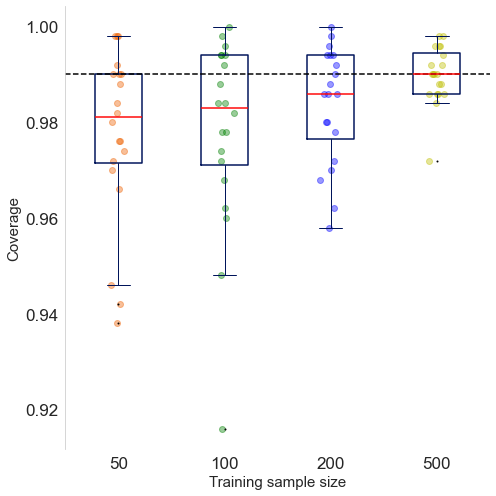

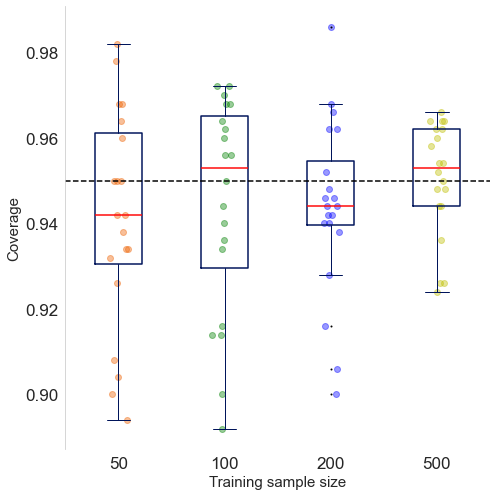

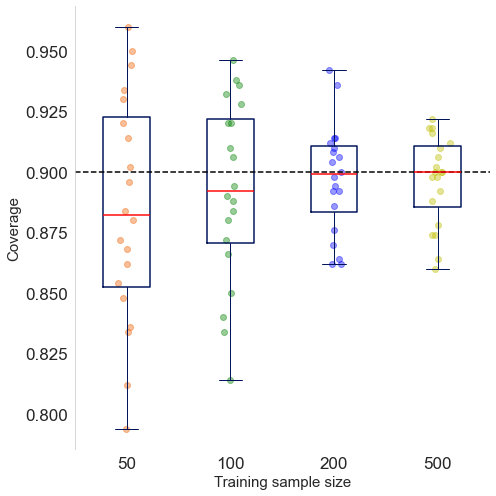

In [46]:
# Plot coverages vs. training sample size
# sns.set_style("whitegrid")
# 
# for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data = data, x='train_size', y='coverage', hue='distance', palette=sns.color_palette()[0:3],
#                 flierprops={"marker": "x"}, dodge=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'white','markersize':'4'})
#     
#     plt.legend(title='Distance')
#     plt.title(f'Coverages vs. Training sample size (alpha={alpha_level})')
#     plt.xlabel('Training sample size')
#     plt.ylabel('Coverage')
#     plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#     plt.show()


# Only for AI

##### Set style options here #####
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

for data, alpha_level in zip([ii_coverage_df_AI_alpha_01, ii_coverage_df_AI_alpha_05, ii_coverage_df_AI_alpha_1], [0.01, 0.05, 0.1]):
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    #Note: when simulations are finalized, tehre should not be any need to select the first 40 (it is done because colukn had different lengths)
    data_50 = data[data['train_size'] == 50].iloc[0:20]
    data_100 = data[data['train_size'] == 100].iloc[0:20]
    data_200 = data[data['train_size'] == 200].iloc[0:20]
    data_500 = data[data['train_size'] == 500].iloc[0:20]

    boxplot_data = pd.DataFrame({
        '50': data_50['II_coverage'].values,
        '100': data_100['II_coverage'].values,
        '200': data_200['II_coverage'].values,
        '500': data_500['II_coverage'].values
    })

    sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"

    #sns.boxplot(data = data, x='train_size', y='II_coverage',
               # flierprops={"marker": "x"}, dodge=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'white','markersize':'4'})

    ax.boxplot(boxplot_data, labels = ['50', '100', '200', '500'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 
    
    vals, names, xs = [],[],[]
    for i, col in enumerate(boxplot_data.columns):
        vals.append(boxplot_data[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    palette = ['#ee6100', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        ax.scatter(x, val, alpha=0.4, color=c)
    sns.despine(bottom=True) # removes right and top axis lines

    #plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)
    ax.set_xlabel('Training sample size', fontsize=15)
    ax.set_ylabel('Coverage', fontsize=15)
    ax.tick_params(labelsize=17)
    ax.axhline(y=1-alpha_level, color='black', linestyle='dashed')
    ax.grid(False)
    fig.tight_layout()
    fig.savefig('SPD_N_vs_II_coverage.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
    plt.show()

In [12]:
#for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):   
#    if alpha_level == 0.01:
#        coverage_df = coverage_df_combined_alpha_01
#    elif alpha_level == 0.05:
#        coverage_df = coverage_df_combined_alpha_05
#    else:
#        coverage_df = coverage_df_combined_alpha_1
#
#    coverage_df_LC = coverage_df[coverage_df['distance'] == 'LC']
#    coverage_df_AI = coverage_df[coverage_df['distance'] == 'AI']
#    coverage_df_LE = coverage_df[coverage_df['distance'] == 'LE']
#    
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LC, x='df', y='coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, LC distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_AI, x='df', y='coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, AI distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LE, x='df', y='coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()

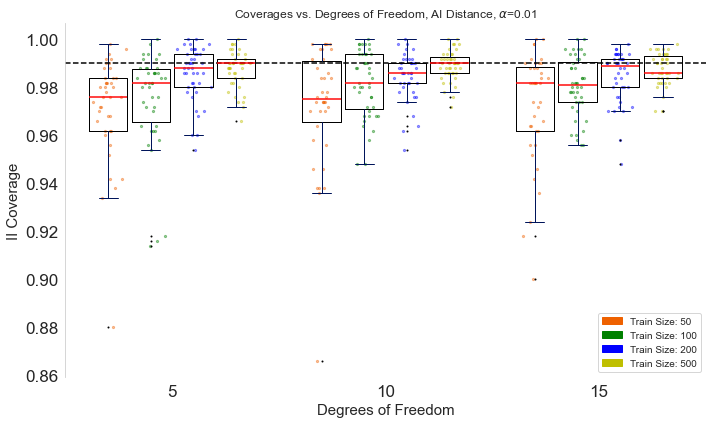

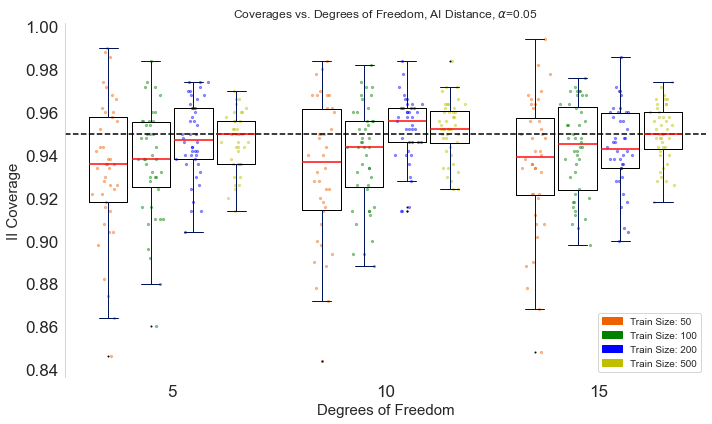

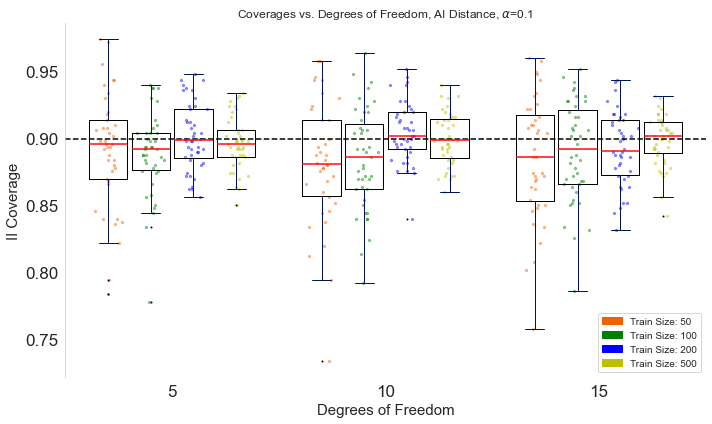

In [47]:
for data, alpha_level in zip(
    [ii_coverage_df_AI_alpha_01, ii_coverage_df_AI_alpha_05, ii_coverage_df_AI_alpha_1], 
    [0.01, 0.05, 0.1]):
    if alpha_level == 0.01:
        coverage_df = ii_coverage_df_AI_alpha_01
    elif alpha_level == 0.05:
        coverage_df = ii_coverage_df_AI_alpha_05
    else:
        coverage_df = ii_coverage_df_AI_alpha_1

    # Extract unique train sizes and degrees of freedom
    train_sizes = sorted(coverage_df['train_size'].unique())
    dfs = sorted(coverage_df['df'].unique())

    # Prepare the data for boxplots
    grouped_data = [
        [coverage_df.loc[(coverage_df['df'] == df) & (coverage_df['train_size'] == N), 'II_coverage']
            for N in train_sizes]
        for df in dfs ]

    # Plotting
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    for i, group in enumerate(grouped_data):
        #In this loop, select the degrees of freedom
        base_position = 1 + i * (len(train_sizes) + 1)  # spacing between groups

        for j, ts_data in enumerate(group):
            #In this loop, select the train sizes. ts_data is the dataset for a given train size and df
            pos = base_position + j

            #ax.boxplot(ts_data, positions=[pos], widths=1, patch_artist=True, 
            #            boxprops=dict(facecolor=palette[j], alpha=.9),
            #            flierprops={'marker': 'x', 'color': 'red'})
            ax.boxplot(ts_data, positions=[pos], widths = .9, notch=False, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

    
            palette = ['#ee6100', 'g', 'b', 'y']
            for x, val in zip(np.random.normal(pos, 0.14, ts_data.shape[0]), ts_data):
                ax.scatter(x, val, alpha=0.4, color = palette[j], s = 5)


    sns.despine(bottom=True) # removes right and top axis lines

    # Formatting
    ax.axhline(y = 1 - alpha_level, color='black', linestyle='dashed', label=f'1 - $\\alpha$')
    ax.set_title(f'Coverages vs. Degrees of Freedom, AI Distance, $\\alpha$={alpha_level}')
    ax.set_xticks(
        ticks=[1 + i * (len(train_sizes) + 1) + (len(train_sizes) - 1) / 2 for i in range(len(dfs))],
        labels=dfs
    )
    ax.tick_params(labelsize=17)
    ax.set_xlim(0, len(dfs) * (len(train_sizes) + 1))
    ax.set_xlabel('Degrees of Freedom', fontsize=15)
    ax.set_ylabel('II Coverage', fontsize=15)
    legend_handles = [
        mpatches.Patch(color=palette[j], label=f'Train Size: {train_sizes[j]}') 
        for j in range(len(train_sizes))
    ]
    ax.legend(handles=legend_handles, loc='lower right')
    ax.grid(False)
    fig.tight_layout()
    fig.savefig('SPD_df_vs_II_coverage.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
    plt.show()

In [14]:
# Note: What is interesting is to see the decaay in the radius as df increases, but 
# comparing the radius between the distances is not informative since the magnitudes depend
# on the distance used

#for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):   
#    if alpha_level == 0.01:
#        coverage_df = coverage_df_combined_alpha_01
#    elif alpha_level == 0.05:
#        coverage_df = coverage_df_combined_alpha_05
#    else:
#        coverage_df = coverage_df_combined_alpha_1
#
#    coverage_df_LC = coverage_df[coverage_df['distance'] == 'LC']
#    coverage_df_AI = coverage_df[coverage_df['distance'] == 'AI']
#    coverage_df_LE = coverage_df[coverage_df['distance'] == 'LE']
#    
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LC, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Prediction ball radius vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.ylabel('Radius')
#    plt.xlabel('Degrees of freedom')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_AI, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Prediction ball radius vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.ylabel('Radius')
#    plt.xlabel('Degrees of freedom')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LE, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Prediction ball radius vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.ylabel('Radius')
#    plt.xlabel('Degrees of freedom')
#    plt.legend()
#    plt.show()

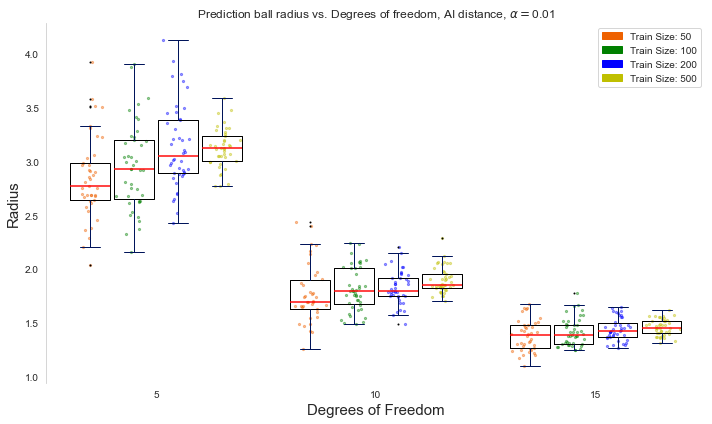

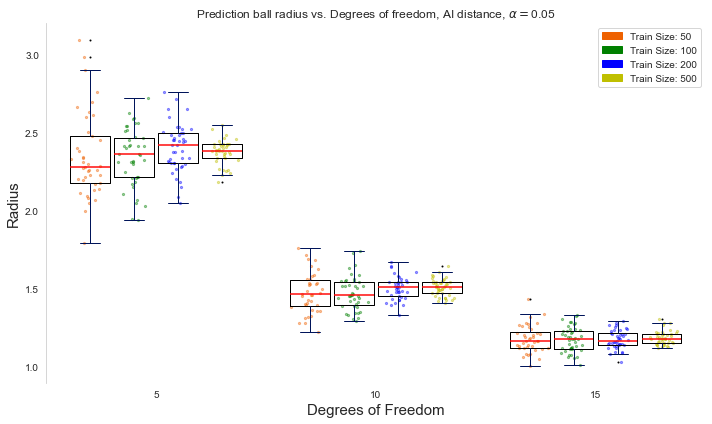

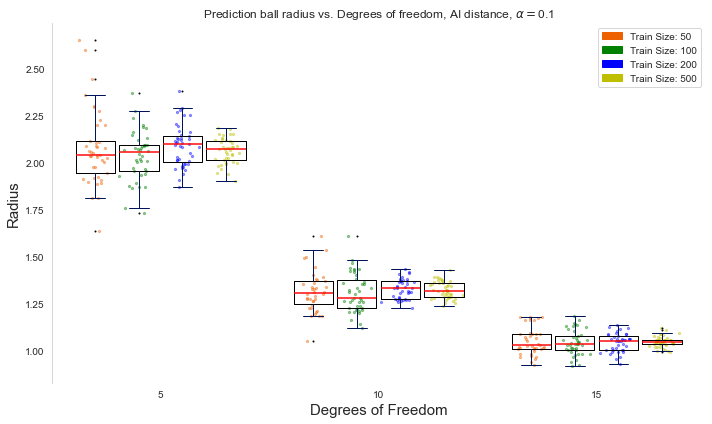

In [48]:
for data, alpha_level in zip(
    [ii_coverage_df_AI_alpha_01, ii_coverage_df_AI_alpha_05, ii_coverage_df_AI_alpha_1], 
    [0.01, 0.05, 0.1]):
    if alpha_level == 0.01:
        coverage_df = ii_coverage_df_AI_alpha_01
    elif alpha_level == 0.05:
        coverage_df = ii_coverage_df_AI_alpha_05
    else:
        coverage_df = ii_coverage_df_AI_alpha_1

    # Extract unique train sizes and degrees of freedom
    train_sizes = sorted(coverage_df['train_size'].unique())
    dfs = sorted(coverage_df['df'].unique())

    # Prepare the data for boxplots
    grouped_data = [
        [coverage_df.loc[(coverage_df['df'] == df) & (coverage_df['train_size'] == N), 'OOB_quantile']
            for N in train_sizes]
        for df in dfs ]

    # Plotting
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    for i, group in enumerate(grouped_data):
        #In this loop, select the degrees of freedom
        base_position = 1 + i * (len(train_sizes) + 1)  # spacing between groups

        for j, ts_data in enumerate(group):
            #In this loop, select the train sizes. ts_data is the dataset for a given train size and df
            pos = base_position + j

            #ax.boxplot(ts_data, positions=[pos], widths=1, patch_artist=True, 
            #            boxprops=dict(facecolor=palette[j], alpha=.9),
            #            flierprops={'marker': 'x', 'color': 'red'})
            ax.boxplot(ts_data, positions=[pos], widths = .9, notch=False, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

    
            palette = ['#ee6100', 'g', 'b', 'y']
            for x, val in zip(np.random.normal(pos, 0.14, ts_data.shape[0]), ts_data):
                ax.scatter(x, val, alpha=0.4, color = palette[j], s = 5)


    sns.despine(bottom=True) # removes right and top axis lines

    # Formatting
    ax.set_title(f'Prediction ball radius vs. Degrees of freedom, AI distance, $\\alpha=${alpha_level}')
    ax.set_xticks(
        ticks=[1 + i * (len(train_sizes) + 1) + (len(train_sizes) - 1) / 2 for i in range(len(dfs))],
        labels=dfs
    )
    ax.set_xlim(0, len(dfs) * (len(train_sizes) + 1))
    ax.set_xlabel('Degrees of Freedom', fontsize=15)
    ax.set_ylabel('Radius', fontsize=15)
    legend_handles = [
        mpatches.Patch(color=palette[j], label=f'Train Size: {train_sizes[j]}') 
        for j in range(len(train_sizes))
    ]
    ax.legend(handles=legend_handles, loc='upper right')
    ax.grid(False)
    fig.tight_layout()
    fig.savefig('SPD_radius_vs_df.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
    plt.show()

# TYPE III

In [29]:
MC = 20
n_estimations = 20

zeros_init = np.zeros(shape = (n_estimations, 3))
cov = np.zeros(shape = (n_estimations, 3))

diccionario = {'df_5': {'AI': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LC': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LE': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}}, 'df_10': {'AI': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LC': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LE': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}}, 'df_15': {'AI': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LC': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}, 'LE': {'50': zeros_init, '100': zeros_init, '200': zeros_init, '500': zeros_init}}}

# Obtain n_estimations estimations of Type III coverage error for each distance and N, to calculate the mean of the estimations and the sample variance
for df in [5, 10, 15]:
    for dist in ['AI']:
        # Select the distance analyzed
        #if dist == 'AI':
        coverage_df = coverage_df_AI[coverage_df_AI['df'] == df]
        # M = CustomAffineInvariant(dim = 2)
        # elif dist == 'LC':
        #     coverage_df = coverage_df_LC[coverage_df_LC['df'] == df]
        #     M = LogCholesky(dim = 2)
        # else:
        #     coverage_df = coverage_df_LE[coverage_df_LE['df'] == df]
        #     M = LogEuclidean(dim = 2)

        for N in [50, 100, 200, 500]:
            # Select the size of the training set
            coverage_df_N = coverage_df[coverage_df['train_size'] == N]

            for estimation in range(n_estimations):
                yesno = np.zeros(3)
                new_ys = sim_regression_matrices(Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
                                                t = np.repeat(0, MC),  
                                               df = df)
                lns = coverage_df_N.sample(n=MC, replace=False)
                i = 0
                for _, ln in lns.iterrows():
                    # Randomly select a row from the dataframe
                    
                    # Retrieve the data           
                    new_y = new_ys['y'][i]
                    new_pred = ln['forest'].predict_matrix(np.array([0]).reshape(-1,1))

                    # Store the selected values
                    yesno = np.vstack((yesno, M.d(new_pred, new_y) <= ln['OOB_quantile']))
                    i += 1
                cov[estimation, :] = yesno[1:,:].sum(axis=0) / MC
                
            diccionario['df_'+str(df)][dist][str(N)] = np.copy(cov)

In [17]:
# Obtain 25 estimations of Type I coverage error for each distance and N, to calculate the mean of the estimations and the sample variance
#dist = 'LC'
#
#for df in [2, 5]:
#        
#    coverage_df = coverage_df_LC[coverage_df_LC['df'] == df]
#    M = LogCholesky(dim = 2)
#
#    for N in [50, 100, 200, 500]:
#        # Select the size of the training set
#        coverage_df_N = coverage_df[coverage_df['train_size'] == N]
#
#        for estimation in range(n_estimations):
#            yesno = np.zeros(3)
#
#            for _ in range(m):
#                # Randomly select a row from the dataframe
#                random_row = coverage_df_N.sample(n=1)
#                
#                # Retrieve the data
#                c_dq = 2 * np.exp((1 / 2) * sum([digamma((df - i + 1) / 2) for i in range(1, 2 + 1)]))
#                sigma_t = Sigma_t(0, (Sigma_1, Sigma_2, Sigma_3))[0]
#                sample_Y = np.array([spd_to_log_chol(1/c_dq*wishart( df=df, scale = sigma_t ).rvs( size=1 ))])
#                y_test_datum = MetricData(M, sample_Y)
#                test_pred = MetricData(M, np.array([random_row['forest'].values[0].predict_matrix(np.array([0]).reshape(-1,1))]))
#                
#                # Store the selected values
#                yesno = np.vstack((yesno, M.d(test_pred, y_test_datum) <= random_row['OOB_quantile'].values[0]))
#            cov[estimation, :] = yesno[1:,:].sum(axis=0) / m
#            
#        diccionario['df_'+str(df)][dist][str(N)] = np.copy(cov)

In [18]:
for df in [5, 10, 15]:    
    for dist in ['AI']:
        for N in [50, 100, 200, 500]:
            print(f"{df} degrees of freedom, N = {N}, {dist} distance, mean of Type I coverage estimates: ", np.mean(diccionario['df_'+str(df)][dist][str(N)], axis = 0)) 
            print(f"{df} degrees of freedom, N = {N}, {dist} distance, standard deviation of Type I coverage estimates: ", np.sqrt(np.var(diccionario['df_'+str(df)][dist][str(N)], axis = 0))  )   

5 degrees of freedom, N = 50, AI distance, mean of Type I coverage estimates:  [0.975 0.925 0.875]
5 degrees of freedom, N = 50, AI distance, standard deviation of Type I coverage estimates:  [0.10897247 0.17853571 0.21650635]
5 degrees of freedom, N = 100, AI distance, mean of Type I coverage estimates:  [0.95  0.925 0.9  ]
5 degrees of freedom, N = 100, AI distance, standard deviation of Type I coverage estimates:  [0.15       0.17853571 0.2       ]
5 degrees of freedom, N = 200, AI distance, mean of Type I coverage estimates:  [0.975 0.925 0.9  ]
5 degrees of freedom, N = 200, AI distance, standard deviation of Type I coverage estimates:  [0.10897247 0.17853571 0.25495098]
5 degrees of freedom, N = 500, AI distance, mean of Type I coverage estimates:  [1.   1.   0.95]
5 degrees of freedom, N = 500, AI distance, standard deviation of Type I coverage estimates:  [0.   0.   0.15]
10 degrees of freedom, N = 50, AI distance, mean of Type I coverage estimates:  [0.95 0.9  0.85]
10 degrees

In [19]:
# Prepare data for the DataFrame
rows = []
index = []

for df in [5, 10, 15]:
    for N in [50, 100, 200, 500]:
        row = []
        for dist in ['AI']:
            means = np.mean(diccionario[f'df_{df}'][dist][str(N)], axis=0)
            stds = np.sqrt(np.var(diccionario[f'df_{df}'][dist][str(N)], axis=0))
            # Format as "mean (std)"
            formatted_values = [f"{means[i]:.3f} ({stds[i]:.3f})" for i in range(3)]
            row.extend(formatted_values)
        rows.append(row)
        index.append((f"df={df}", f"N={N}"))

# MultiIndex for rows and columns
row_index = pd.MultiIndex.from_tuples(index, names=["df", "N"])
col_index = pd.MultiIndex.from_product(
    [["AI"], ["0.01", "0.05", "0.1"]],
    names=["Distance", "Significance Level"]
)

# Create the DataFrame
df_iii = pd.DataFrame(rows, index=row_index, columns=col_index)
# Display the DataFrame
df_iii

Distance                       AI                              
Significance Level           0.01           0.05            0.1
df    N                                                        
df=5  N=50          0.975 (0.109)  0.925 (0.179)  0.875 (0.217)
      N=100         0.950 (0.150)  0.925 (0.179)  0.900 (0.200)
      N=200         0.975 (0.109)  0.925 (0.179)  0.900 (0.255)
      N=500         1.000 (0.000)  1.000 (0.000)  0.950 (0.150)
df=10 N=50          0.950 (0.150)  0.900 (0.200)  0.850 (0.229)
      N=100         1.000 (0.000)  0.975 (0.109)  0.925 (0.179)
      N=200         0.975 (0.109)  0.925 (0.179)  0.825 (0.238)
      N=500         1.000 (0.000)  0.975 (0.109)  0.975 (0.109)
df=15 N=50          0.925 (0.179)  0.925 (0.179)  0.800 (0.292)
      N=100         1.000 (0.000)  1.000 (0.000)  0.950 (0.150)
      N=200         1.000 (0.000)  0.975 (0.109)  0.900 (0.200)
      N=500         1.000 (0.000)  1.000 (0.000)  0.950 (0.150)

In [20]:
# Apply formatting to all cells
df_iii= df_iii.applymap(format_cell)

latex_iii = df_iii.to_latex(index=True, multirow=True, multicolumn=True, multicolumn_format='c', bold_rows=True, float_format= "%.3f" , caption='Type I error coverage for different distances, degrees of freedom and sample sizes', label='tab:typeIerrorcoverage')
print(latex_iii)

\begin{table}
\caption{Type I error coverage for different distances, degrees of freedom and sample sizes}
\label{tab:typeIerrorcoverage}
\begin{tabular}{lllll}
\toprule
 & Distance & \multicolumn{3}{c}{AI} \\
 & Significance Level & 0.01 & 0.05 & 0.1 \\
df & N &  &  &  \\
\midrule
\multirow[t]{4}{*}{\textbf{df=5}} & \textbf{N=50} & 0.975 (0.109) & 0.925 (0.179) & 0.875 (0.217) \\
\textbf{} & \textbf{N=100} & 0.950 (0.150) & 0.925 (0.179) & 0.900 (0.200) \\
\textbf{} & \textbf{N=200} & 0.975 (0.109) & 0.925 (0.179) & 0.900 (0.255) \\
\textbf{} & \textbf{N=500} & 1.000 (0.000) & 1.000 (0.000) & 0.950 (0.150) \\
\cline{1-5}
\multirow[t]{4}{*}{\textbf{df=10}} & \textbf{N=50} & 0.950 (0.150) & 0.900 (0.200) & 0.850 (0.229) \\
\textbf{} & \textbf{N=100} & 1.000 (0.000) & 0.975 (0.109) & 0.925 (0.179) \\
\textbf{} & \textbf{N=200} & 0.975 (0.109) & 0.925 (0.179) & 0.825 (0.238) \\
\textbf{} & \textbf{N=500} & 1.000 (0.000) & 0.975 (0.109) & 0.975 (0.109) \\
\cline{1-5}
\multirow[t]{4}{*}{\te

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_20651/3187574333.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_iii= df_iii.applymap(format_cell)


# Type IV

In [21]:
coverage_df_AI['IV_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_AI))]
#coverage_df_LC['IV_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_LC))]
#coverage_df_LE['IV_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_LE))]

MC = 500
for i, ln in coverage_df_AI.iterrows():
    #Calculate coverage for every dataset L_n (Type IV):
    df = ln['df']
    new_pred = MetricData(M, np.array([ln['forest'].predict_matrix(np.array([0]).reshape(-1,1))]))
    new_y = MetricData(M, np.array(sim_regression_matrices(Sigmas=(Sigma_1, Sigma_2, Sigma_3), t = np.repeat(0, MC), df=df)['y']))
    new_pred = MetricData(M, np.tile(new_pred, (MC, 1, 1)))
    coverage_df_AI.at[i, 'IV_coverage'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

############################################
# Obtain Type IV coverages for log-Euclidean distance
# M = CustomLogEuclidean(dim = 2)
# 
# for i, ln in coverage_df_LE.iterrows():
#     c = 0
#     #Calculate coverage for every dataset L_n (Type IV):
#     df = ln['df']
#     c_dq = 2 * np.exp((1 / 2) * sum([digamma((df - i + 1) / 2) for i in range(1, 2 + 1)]))
#     test_pred = MetricData(M, np.array([ln['forest'].predict_matrix(np.array([0]).reshape(-1,1))]))
# 
#     sample_Y = np.array([ 1/c_dq*wishart( df = df, scale = sigma_t ).rvs( size=1 ) for _ in range(MC)])
#     y_test_datum = MetricData(M, sample_Y)
#     test_pred = MetricData(M, np.tile(test_pred, (MC, 1, 1)))
#     coverage_df_LE.at[i, 'IV_coverage'] = np.sum(M.d(test_pred, y_test_datum).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC
# 
# ############################################
# # Obtain Type IV coverages for log-Cholesky distance
# M = LogCholesky(dim = 2)
# for i, ln in coverage_df_LC.iterrows():
#     c = 0
#     #Calculate coverage for every dataset L_n (Type IV):
#     df = ln['df']
#     c_dq = 2 * np.exp((1 / 2) * sum([digamma((df - i + 1) / 2) for i in range(1, 2 + 1)]))
#     test_pred = MetricData(M, np.array([ln['forest'].predict_matrix(np.array([0]).reshape(-1,1))]))
# 
#     sample_Y = np.array([spd_to_log_chol( 1/c_dq*wishart( df = df, scale = sigma_t ).rvs( size=1 ) ) for _ in range(MC)])
#     y_test_datum = MetricData(M, sample_Y)
#     test_pred = MetricData(M, np.tile(test_pred, (MC, 1)))
#     coverage_df_LC.at[i, 'IV_coverage'] = np.sum(M.d(test_pred, y_test_datum).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

In [22]:
# coverage_df_combined = pd.concat([coverage_df_AI.copy(), coverage_df_LC.copy(), coverage_df_LE.copy()], ignore_index=True)
# 
# coverage_df_combined_alpha_01 = coverage_df_combined.copy()
# coverage_df_combined_alpha_05 = coverage_df_combined.copy()
# coverage_df_combined_alpha_1 = coverage_df_combined.copy()
# 
# coverage_df_combined_alpha_01['IV_coverage'] = coverage_df_combined['IV_coverage'].apply(lambda x: x[0])
# coverage_df_combined_alpha_01['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[0])
# 
# coverage_df_combined_alpha_05['IV_coverage'] = coverage_df_combined['IV_coverage'].apply(lambda x: x[1])
# coverage_df_combined_alpha_05['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[1])
# 
# coverage_df_combined_alpha_1['IV_coverage'] = coverage_df_combined['IV_coverage'].apply(lambda x: x[2])
# coverage_df_combined_alpha_1['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[2])
# 
# coverage_df_combined_alpha_01.head()
# coverage_df_combined_alpha_05.head()
# coverage_df_combined_alpha_1.head()

In [50]:
iv_coverage_df_AI_alpha_01 = coverage_df_AI.copy()
iv_coverage_df_AI_alpha_05 = coverage_df_AI.copy()
iv_coverage_df_AI_alpha_1 = coverage_df_AI.copy()

iv_coverage_df_AI_alpha_01['IV_coverage'] = coverage_df_AI['IV_coverage'].apply(lambda x: x[0])

iv_coverage_df_AI_alpha_05['IV_coverage'] = coverage_df_AI['IV_coverage'].apply(lambda x: x[1])

iv_coverage_df_AI_alpha_1['IV_coverage'] = coverage_df_AI['IV_coverage'].apply(lambda x: x[2])

iv_coverage_df_AI_alpha_01.head()
iv_coverage_df_AI_alpha_05.head()
iv_coverage_df_AI_alpha_1.head()

,sample_index,train_size,df,y_train_data,train_predictions,OOB_errors,OOB_quantile,forest,distance,II_coverage,IV_coverage
0,35,100,10,"[[[0.4722936574719066, -0.3248004451639332], [...","[[[1.0233693790038476, -0.6826328393111593], [...","[1.8486935742231794, 1.3211787510884274, 0.349...","[1.8019706639559985, 1.5242392672675238, 1.327...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.994, 0.956, 0.906]",0.578
1,24,500,5,"[[[2.8774669074965162, -1.5206495121228487], [...","[[[1.6837731897318466, -0.9868755076054906], [...","[1.0282784597331178, 0.9057890894961751, 1.247...","[3.1394579212867266, 2.3649339199688457, 1.994...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.986, 0.926, 0.864]",0.900
2,18,200,5,"[[[1.6227297378385266, -1.5438405469462333], [...","[[[1.4111668310225487, -0.926847315436739], [-...","[1.8397184131872726, 1.2663943828963289, 1.028...","[3.491496496122414, 2.2724351659257405, 1.9720...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.998, 0.938, 0.862]",0.880
3,12,50,5,"[[[0.12069691135039363, -0.14208909431633288],...","[[[0.4534984453059997, -0.32873529122287215], ...","[2.6331414030598634, 0.4032095249565652, 0.841...","[2.666355910581911, 2.3476972705876764, 2.0650...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.972, 0.942, 0.88]",0.836
4,41,50,15,"[[[0.9032542525079421, -0.6950978559135421], [...","[[[0.9729803629247916, -0.6291270202047456], [...","[0.7481233569635565, 0.9915847771342788, 1.373...","[1.4526772866698225, 1.1917532099928592, 1.011...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.99, 0.932, 0.854]",0.904


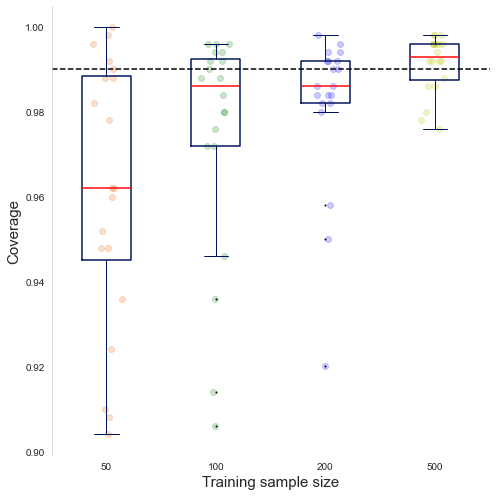

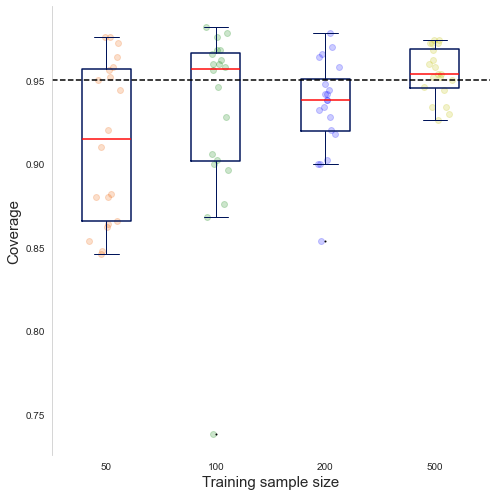

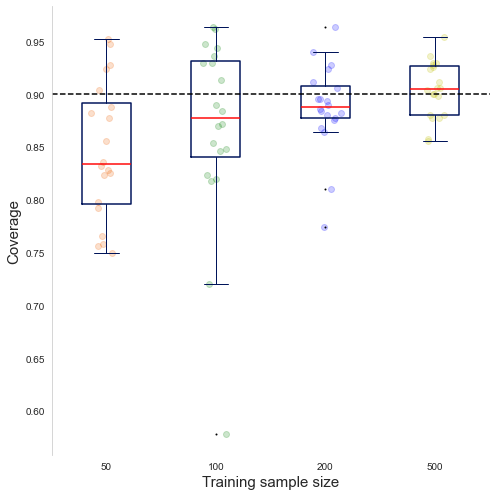

In [51]:
# Plot coverages vs. training sample size

# Only for AI

##### Set style options here #####
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

for data, alpha_level in zip([iv_coverage_df_AI_alpha_01, iv_coverage_df_AI_alpha_05, iv_coverage_df_AI_alpha_1], [0.01, 0.05, 0.1]):
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    #Note: when simulations are finalized, tehre should not be any need to select the first 40 (it is done because colukn had different lengths)
    data_50 = data[data['train_size'] == 50].iloc[0:20]
    data_100 = data[data['train_size'] == 100].iloc[0:20]
    data_200 = data[data['train_size'] == 200].iloc[0:20]
    data_500 = data[data['train_size'] == 500].iloc[0:20]

    boxplot_data = pd.DataFrame({
        '50': data_50['IV_coverage'].values,
        '100': data_100['IV_coverage'].values,
        '200': data_200['IV_coverage'].values,
        '500': data_500['IV_coverage'].values
    })

    #sns.boxplot(data = data, x='train_size', y='IV_coverage',
               # flierprops={"marker": "x"}, dodge=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'white','markersize':'4'})
    ax.boxplot(boxplot_data, labels = ['50', '100', '200', '500'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 
    vals, names, xs = [],[],[]
    for i, col in enumerate(boxplot_data.columns):
        vals.append(boxplot_data[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.06, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    palette = ['#ee6100', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        ax.scatter(x, val, alpha=0.2, color=c)
    sns.despine(bottom=True) # removes right and top axis lines

    #plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)
    ax.set_xlabel('Training sample size', fontsize=15)
    ax.set_ylabel('Coverage', fontsize=15)
    ax.axhline(y=1-alpha_level, color='black', linestyle='dashed')
    ax.grid(False)
    fig.tight_layout()
    fig.savefig('SPD_N_vs_IV_coverage.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
    plt.show()

In [25]:
#for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):   
#    if alpha_level == 0.01:
#        coverage_df = coverage_df_combined_alpha_01
#    elif alpha_level == 0.05:
#        coverage_df = coverage_df_combined_alpha_05
#    else:
#        coverage_df = coverage_df_combined_alpha_1
#
#    cov_df_LC = coverage_df[coverage_df['distance'] == 'LC']
#    cov_df_AI = coverage_df[coverage_df['distance'] == 'AI']
#    cov_df_LE = coverage_df[coverage_df['distance'] == 'LE']
#    
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=cov_df_LC, x='df', y='IV_coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, LC distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=cov_df_AI, x='df', y='IV_coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, AI distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=cov_df_LE, x='df', y='IV_coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()

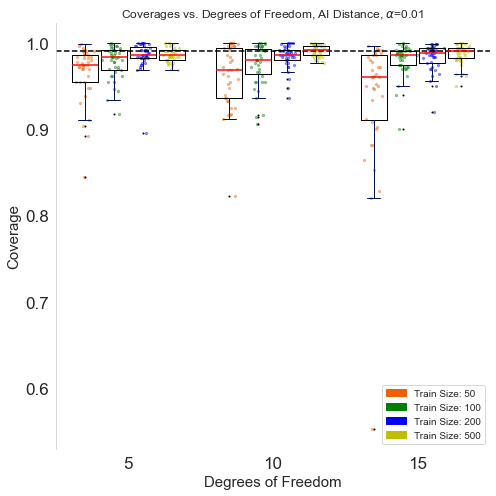

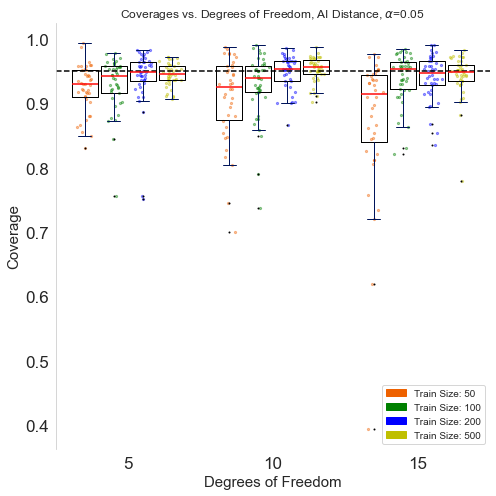

In [ ]:
for data, alpha_level in zip(
    [iv_coverage_df_AI_alpha_01, iv_coverage_df_AI_alpha_05, iv_coverage_df_AI_alpha_1], 
    [0.01, 0.05, 0.1]):
    if alpha_level == 0.01:
        coverage_df = iv_coverage_df_AI_alpha_01
    elif alpha_level == 0.05:
        coverage_df = iv_coverage_df_AI_alpha_05
    else:
        coverage_df = iv_coverage_df_AI_alpha_1

    # Extract unique train sizes and degrees of freedom
    train_sizes = sorted(coverage_df['train_size'].unique())
    dfs = sorted(coverage_df['df'].unique())

    # Prepare the data for boxplots
    grouped_data = [
        [coverage_df.loc[(coverage_df['df'] == df) & (coverage_df['train_size'] == N), 'IV_coverage']
            for N in train_sizes]
        for df in dfs ]

    # Plotting
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    for i, group in enumerate(grouped_data):
        #In this loop, select the degrees of freedom
        base_position = 1 + i * (len(train_sizes) + 1)  # spacing between groups

        for j, ts_data in enumerate(group):
            #In this loop, select the train sizes. ts_data is the dataset for a given train size and df
            pos = base_position + j

            #ax.boxplot(ts_data, positions=[pos], widths=1, patch_artist=True, 
            #            boxprops=dict(facecolor=palette[j], alpha=.9),
            #            flierprops={'marker': 'x', 'color': 'red'})
            ax.boxplot(ts_data, positions=[pos], widths = .9, notch=False, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

    
            palette = ['#ee6100', 'g', 'b', 'y']
            for x, val in zip(np.random.normal(pos, 0.14, ts_data.shape[0]), ts_data):
                ax.scatter(x, val, alpha=0.4, color = palette[j], s = 5)


    sns.despine(bottom=True) # removes right and top axis lines

    # Formatting
    ax.axhline(y = 1 - alpha_level, color='black', linestyle='dashed', label=f'1 - $\\alpha$')
    ax.set_title(f'Coverages vs. Degrees of Freedom, AI Distance, $\\alpha$={alpha_level}')
    ax.set_xticks(
        ticks=[1 + i * (len(train_sizes) + 1) + (len(train_sizes) - 1) / 2 for i in range(len(dfs))],
        labels=dfs
    )
    ax.set_xlim(0, len(dfs) * (len(train_sizes) + 1))
    ax.set_xlabel('Degrees of Freedom', fontsize=15)
    ax.set_ylabel('Coverage', fontsize=15)
    ax.tick_params(labelsize=17)
    legend_handles = [
        mpatches.Patch(color=palette[j], label=f'Train Size: {train_sizes[j]}') 
        for j in range(len(train_sizes))
    ]
    ax.legend(handles=legend_handles, loc='lower right')
    ax.grid(False)
    fig.tight_layout()
    fig.savefig('SPD_df_vs_IV_coverage.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
    plt.show()